# Step 01: Import Spark Session and initialize Spark

In [1]:
# create entry points to spark
from pyspark import SparkContext # Spark
from pyspark.sql import SparkSession # Spark SQL

# We add this line to avoid an error : "Cannot run multiple SparkContexts at once". 
# If there is an existing spark context, we will reuse it instead of creating a new context.
sc = SparkContext.getOrCreate()

# local[4]: run Spark locally with 4 working processors as logical cores on your machine.
# In the field of `master`, we use a local server with as many working processors (or threads) as possible (i.e. `local[4]`). 
# If we want Spark to run locally with 'k' worker threads, we can specify as `local[k]`.
# The `appName` field is a name to be shown on the Sparking cluster UI. 

# If there is no existing spark context, we now create a new context
if (sc is None):
    sc = SparkContext(master="local[4]", appName="Assignment 2")
spark = SparkSession(sparkContext=sc)

# Step 02: Load the dataset and print the schema and total number of entries

## If the csv file have a header (column names in the first row) then set header=true. This will use the first row in the csv file as the dataframe's column names. Setting header=false (default option) will result in a dataframe with default column names: _c0, _c1, _c2, etc.

In [2]:
df = spark.read.csv("weatherAUS.csv", inferSchema=True, header=True).toDF("Date","Location","MinTemp","MaxTemp","Rainfall","Evaporation","Sunshine","WindGustDir","WindGustSpeed","WindDir9am","WindDir3pm","WindSpeed9am","WindSpeed3pm","Humidity9am","Humidity3pm","Pressure9am","Pressure3pm","Cloud9am","Cloud3pm","Temp9am","Temp3pm","RainToday","RainTomorrow")

### Total number of entries in the dataset

In [3]:
df.count()

142193

In [4]:
df.printSchema()

root
 |-- Date: timestamp (nullable = true)
 |-- Location: string (nullable = true)
 |-- MinTemp: string (nullable = true)
 |-- MaxTemp: string (nullable = true)
 |-- Rainfall: string (nullable = true)
 |-- Evaporation: string (nullable = true)
 |-- Sunshine: string (nullable = true)
 |-- WindGustDir: string (nullable = true)
 |-- WindGustSpeed: string (nullable = true)
 |-- WindDir9am: string (nullable = true)
 |-- WindDir3pm: string (nullable = true)
 |-- WindSpeed9am: string (nullable = true)
 |-- WindSpeed3pm: string (nullable = true)
 |-- Humidity9am: string (nullable = true)
 |-- Humidity3pm: string (nullable = true)
 |-- Pressure9am: string (nullable = true)
 |-- Pressure3pm: string (nullable = true)
 |-- Cloud9am: string (nullable = true)
 |-- Cloud3pm: string (nullable = true)
 |-- Temp9am: string (nullable = true)
 |-- Temp3pm: string (nullable = true)
 |-- RainToday: string (nullable = true)
 |-- RainTomorrow: string (nullable = true)



# B. Data Cleaning and Processing
## Step 03: Delete columns from the dataset
### * is used for unpacking the list. Here we have unpacked our list data and passed it to the drop function. Here every elements of the list dropped_columns will be unpacked.

In [5]:
dropped_columns = ['Date','Location','Evaporation','Sunshine','Cloud9am','Cloud3pm','Temp9am','Temp3pm']
df = df.drop(*dropped_columns)

In [6]:
#For testing purpose
df.printSchema()

root
 |-- MinTemp: string (nullable = true)
 |-- MaxTemp: string (nullable = true)
 |-- Rainfall: string (nullable = true)
 |-- WindGustDir: string (nullable = true)
 |-- WindGustSpeed: string (nullable = true)
 |-- WindDir9am: string (nullable = true)
 |-- WindDir3pm: string (nullable = true)
 |-- WindSpeed9am: string (nullable = true)
 |-- WindSpeed3pm: string (nullable = true)
 |-- Humidity9am: string (nullable = true)
 |-- Humidity3pm: string (nullable = true)
 |-- Pressure9am: string (nullable = true)
 |-- Pressure3pm: string (nullable = true)
 |-- RainToday: string (nullable = true)
 |-- RainTomorrow: string (nullable = true)



## Step 04: Print the number of missing data in each column.

In [7]:
def countNAData(column):
    return df.filter(df[column]=='NA').count()

#### To get the list of names from the schema we can use schema.names which actually returns the column names.

In [8]:
sf = df.schema.names

In [9]:
for col in sf:
    print(col ,'  ', countNAData(col))

MinTemp    637
MaxTemp    322
Rainfall    1406
WindGustDir    9330
WindGustSpeed    9270
WindDir9am    10013
WindDir3pm    3778
WindSpeed9am    1348
WindSpeed3pm    2630
Humidity9am    1774
Humidity3pm    3610
Pressure9am    14014
Pressure3pm    13981
RainToday    1406
RainTomorrow    0


# Step 05: Fill the missing data with average value and maximum occurrence value.

In [10]:
from pyspark.sql import types

In [11]:
numeric_column = ['MinTemp','MaxTemp','Rainfall','WindGustSpeed','WindSpeed9am','WindSpeed3pm','Humidity9am','Humidity3pm','Pressure9am','Pressure3pm']
nonnumeric_columns = ['WindGustDir','WindDir9am','WindDir3pm','RainToday']

In [12]:
from pyspark.sql.functions import udf

#### mylist contains the mean for all the numeric column in numeric_column list. df.describe(['MinTemp']).collect() will provide the count, mean, stddev, min and max for 'MinTemp' column. As well as, nonnumericlist contains maximum frequency value.
#### df.describe(['MinTemp']).collect()[0]['MinTemp'] -> count
#### df.describe(['MinTemp']).collect()[1]['MinTemp'] -> mean
#### df.describe(['MinTemp']).collect()[4]['WindGustDir'] -> maximum frequency of a word in the column.

In [13]:
mylist = []
for i in numeric_column:
    mylist.append(df.describe([i]).collect()[1][i])

In [14]:
nonnumericlist = []
for i in nonnumeric_columns:
    nonnumericlist.append(df.describe([i]).collect()[4][i])

### Creating udf function for each column in order to assign the average value for the numeric column and maximum frequency value for non numeric column where 'NA' was found.

In [15]:
avgColMinTemp = udf(lambda x: mylist[0] if x=='NA' else x)
avgColMaxTemp = udf(lambda x: mylist[1] if x=='NA' else x)
avgColRainfall = udf(lambda x: mylist[2] if x=='NA' else x)
avgColWindGustSpeed = udf(lambda x: mylist[3] if x=='NA' else x)
avgColWindSpeed9am= udf(lambda x: mylist[4] if x=='NA' else x)
avgColWindSpeed3pm= udf(lambda x: mylist[5] if x=='NA' else x)
avgColHumidity9am= udf(lambda x: mylist[6] if x=='NA' else x)
avgColHumidity3pm= udf(lambda x: mylist[7] if x=='NA' else x)
avgColPressure9am= udf(lambda x: mylist[8] if x=='NA' else x)
avgColPressure3pm= udf(lambda x: mylist[9] if x=='NA' else x)
freqWindGustDir = udf(lambda x: nonnumericlist[0] if x=='NA' else x)
freqWindDir9am = udf(lambda x: nonnumericlist[1] if x=='NA' else x)
freqWindDir3pm = udf(lambda x: nonnumericlist[2] if x=='NA' else x)
freqRainToday = udf(lambda x: nonnumericlist[3] if x=='NA' else x)

In [16]:
df = df.withColumn('MinTemp',avgColMinTemp(df['MinTemp']))\
.withColumn('MaxTemp',avgColMaxTemp(df['MaxTemp']))\
.withColumn('Rainfall',avgColRainfall(df['Rainfall']))\
.withColumn('WindGustSpeed',avgColWindGustSpeed(df['WindGustSpeed']))\
.withColumn('WindSpeed9am',avgColWindSpeed9am(df['WindSpeed9am']))\
.withColumn('WindSpeed3pm',avgColWindSpeed3pm(df['WindSpeed3pm']))\
.withColumn('Humidity9am',avgColHumidity9am(df['Humidity9am']))\
.withColumn('Humidity3pm',avgColHumidity3pm(df['Humidity3pm']))\
.withColumn('Pressure9am',avgColPressure9am(df['Pressure9am']))\
.withColumn('Pressure3pm',avgColPressure3pm(df['Pressure3pm']))\
.withColumn('WindGustDir',freqWindGustDir(df['WindGustDir']))\
.withColumn('WindDir9am',freqWindDir9am(df['WindDir9am']))\
.withColumn('WindDir3pm',freqWindDir3pm(df['WindDir3pm']))\
.withColumn('RainToday',freqRainToday(df['RainToday']))

## Step 06: Data transformation

### Type casting has been done- Double for the numeric value columns

In [19]:
from pyspark.sql import types
df =  df.withColumn("MinTemp",df["MinTemp"].cast(types.DoubleType()))\
        .withColumn("MaxTemp",df["MaxTemp"].cast(types.DoubleType()))\
        .withColumn("Rainfall",df["Rainfall"].cast(types.DoubleType()))\
        .withColumn("WindGustSpeed",df["WindGustSpeed"].cast(types.DoubleType()))\
        .withColumn("WindSpeed9am",df["WindSpeed9am"].cast(types.DoubleType()))\
        .withColumn("WindSpeed3pm",df["WindSpeed3pm"].cast(types.DoubleType()))\
        .withColumn("Humidity9am",df["Humidity9am"].cast(types.DoubleType()))\
        .withColumn("Humidity3pm",df["Humidity3pm"].cast(types.DoubleType()))\
        .withColumn("Pressure9am",df["Pressure9am"].cast(types.DoubleType()))\
        .withColumn("Pressure3pm",df["Pressure3pm"].cast(types.DoubleType()))\
        .withColumn("WindGustDir",df["WindGustDir"])\
        .withColumn("WindDir9am",df["WindDir9am"])\
        .withColumn("WindDir3pm",df["WindDir3pm"])\
        .withColumn("RainToday",df["RainToday"])\
        .withColumn("RainTomorrow",df["RainTomorrow"])

In [21]:
from pyspark.ml.feature import StringIndexer

In [22]:
WindGustDir_indexer = StringIndexer(inputCol="WindGustDir", outputCol="WindGustDir_index")
WindDir9am_indexer = StringIndexer(inputCol="WindDir9am", outputCol="WindDir9am_index")
WindDir3pm_indexer = StringIndexer(inputCol="WindDir3pm", outputCol="WindDir3pm_index")
RainToday_indexer = StringIndexer(inputCol="RainToday", outputCol="RainToday_index")
RainTomorrow_indexer = StringIndexer(inputCol="RainTomorrow", outputCol="RainTomorrow_index")

In [23]:
df = WindGustDir_indexer.fit(df).transform(df)
df = WindDir9am_indexer.fit(df).transform(df)
df = WindDir3pm_indexer.fit(df).transform(df)
df = RainToday_indexer.fit(df).transform(df)
df = RainTomorrow_indexer.fit(df).transform(df)

### Since it is told in the marking rubric to drop the orginal columns whose indexing is done.

In [24]:
df = df.drop('WindGustDir','WindDir9am','WindDir3pm','RainToday','RainTomorrow')

# Step 07: Create the feature vector and divide the dataset

In [25]:
from pyspark.ml.feature import VectorAssembler

### VectorAssembler is a transformer that combines a given list of columns into a single vector column "features"

In [26]:
vector_assembler = VectorAssembler(inputCols=["MinTemp", "MaxTemp", "Rainfall", "WindGustSpeed","WindSpeed9am","WindSpeed3pm","Humidity9am","Humidity3pm","Pressure9am","Pressure3pm","WindGustDir_index","WindDir9am_index","WindDir3pm_index","RainToday_index"],outputCol="features")

In [27]:
df = vector_assembler.transform(df)

In [28]:
#I hope will not make any effect after deleting this
#columns since they are not used in the following stages
#df = df.drop("MinTemp", "MaxTemp", "Rainfall", "WindGustSpeed","WindSpeed9am","WindSpeed3pm","Humidity9am","Humidity3pm","Pressure9am","Pressure3pm","WindGustDir_index","WindDir9am_index","WindDir3pm_index","RainToday_index")

### 4. Splitting the dataset between training and test dataset

In [29]:
(trainingData, testData) = df.randomSplit([0.7, 0.3], seed = 2019)

# C. Apply Machine Learning Algorithms

In [30]:
from pyspark.ml.classification import DecisionTreeClassifier

In [31]:
decision_tree = DecisionTreeClassifier(labelCol="RainTomorrow_index", featuresCol="features")

In [32]:
dt_model = decision_tree.fit(trainingData)

In [33]:
dt_predictions = dt_model.transform(testData)

In [34]:
dt_predictions.select('prediction','RainTomorrow_index').show(6)

+----------+------------------+
|prediction|RainTomorrow_index|
+----------+------------------+
|       0.0|               0.0|
|       0.0|               0.0|
|       1.0|               1.0|
|       1.0|               1.0|
|       1.0|               0.0|
|       0.0|               0.0|
+----------+------------------+
only showing top 6 rows



In [35]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
dt_evaluator = MulticlassClassificationEvaluator(\

labelCol="RainTomorrow_index", predictionCol="prediction",\

metricName="accuracy")

dt_accuracy = dt_evaluator.evaluate(dt_predictions)
print("DecisionTreeClassifier Accuracy",dt_accuracy)
print("Test Error = %g " % (1.0 - dt_accuracy))

DecisionTreeClassifier Accuracy 0.8346073176415754
Test Error = 0.165393 


### Run and calculate the accuracy of random forest algorithm

In [36]:
from pyspark.ml.classification import RandomForestClassifier

In [37]:
rf = RandomForestClassifier(labelCol="RainTomorrow_index",\
featuresCol="features", numTrees=10)

In [38]:
rf_model = rf.fit(trainingData)

In [39]:
rf_predictions = rf_model.transform(testData)

In [40]:
rf_predictions.select("prediction", "RainTomorrow_index").show(5)

+----------+------------------+
|prediction|RainTomorrow_index|
+----------+------------------+
|       0.0|               0.0|
|       0.0|               0.0|
|       1.0|               1.0|
|       1.0|               1.0|
|       1.0|               0.0|
+----------+------------------+
only showing top 5 rows



In [41]:
rf_evaluator = MulticlassClassificationEvaluator(labelCol="RainTomorrow_index",\
predictionCol="prediction", metricName="accuracy")

In [42]:
rf_accuracy = rf_evaluator.evaluate(rf_predictions)
print ("RandomForestClassifier Accuracy: ",rf_accuracy)
print("Test Error = %g" % (1.0 - rf_accuracy))

RandomForestClassifier Accuracy:  0.8360755068748543
Test Error = 0.163924


### Run and calculate the accuracy of Logistic Regression

In [43]:
from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression(featuresCol = 'features', labelCol = 'RainTomorrow_index',    maxIter=10)

In [44]:
lr_model = lr.fit(trainingData)

In [45]:
lr_predictions = lr_model.transform(testData)

In [49]:
lr_predictions.select("prediction", "RainTomorrow_index").show(2)

+----------+------------------+
|prediction|RainTomorrow_index|
+----------+------------------+
|       0.0|               0.0|
|       0.0|               0.0|
+----------+------------------+
only showing top 2 rows



In [50]:
lr_evaluator = MulticlassClassificationEvaluator(labelCol="RainTomorrow_index",\
predictionCol="prediction", metricName="accuracy")

In [51]:
lr_accuracy = lr_evaluator.evaluate(lr_predictions)
print ("Logistic Regression Accuracy: ",lr_accuracy)
print("Test Error = %g" % (1.0 - lr_accuracy))

Logistic Regression Accuracy:  0.8176182707993475
Test Error = 0.182382


### Run and calculate the accuracy of Gradient-Boosted Tree Classifier

In [52]:
from pyspark.ml.classification import GBTClassifier

#### if maxIter=10

In [53]:
gbt = GBTClassifier(featuresCol = 'features', labelCol = 'RainTomorrow_index', maxIter=10)

In [54]:
gbt_model = gbt.fit(trainingData)

In [55]:
gbt_predictions = gbt_model.transform(testData)

In [57]:
gbt_predictions.select("prediction", "RainTomorrow_index").show(2)

+----------+------------------+
|prediction|RainTomorrow_index|
+----------+------------------+
|       0.0|               0.0|
|       0.0|               0.0|
+----------+------------------+
only showing top 2 rows



In [58]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
gbt_evaluator = MulticlassClassificationEvaluator(labelCol="RainTomorrow_index",\
predictionCol="prediction", metricName="accuracy")

In [59]:
gbt_accuracy = gbt_evaluator.evaluate(gbt_predictions)

In [60]:
print ("Gradient-Boosted Tree Classifier Accuracy: ",gbt_accuracy)
print("Test Error = %g" % (1.0 - gbt_accuracy))

Gradient-Boosted Tree Classifier Accuracy:  0.8419482638079702
Test Error = 0.158052


#### Bar chart to demonstrate the comparison of their accuracy.
#### DT ->  DecisionTreeClassifier
#### RF ->  RandomForestClassifier
#### LR ->  LogisticRegression
#### GBT -> GBTClassifier

In [63]:
accuracy_list = [dt_accuracy,rf_accuracy,lr_accuracy,gbt_accuracy]
accuracy_name = ["DT","RF","LR","GBT"]

In [64]:
import matplotlib.pyplot as plt
%matplotlib inline
import math
import numpy as np

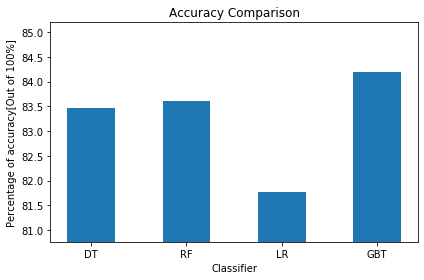

In [67]:
objects= (name for name in accuracy_name)
# prepare data
y_axis = [ac*100 for ac in accuracy_list]

# plot
bar_width = 0.5
objects= accuracy_name
y_pos = np.arange(len(objects))

min_y = min(y_axis) - 1
max_y = max(y_axis) + 1
plt.bar(y_pos, y_axis, bar_width, align='center', color='C0')
plt.xticks(y_pos, objects)
plt.xlabel('Classifier')
plt.ylim([min_y,max_y])
plt.ylabel('Percentage of accuracy[Out of 100%]')
plt.title('Accuracy Comparison')
plt.tight_layout()
plt.show()

### The above bar graph illustrates the percentage of accuracy for each classifier. Overall the accuracy of GBT is better compared to other three classifier. From DT to RF, accuracy increases gradually but for LR it is suddenly dropped. Again for GBT it is jumped suddenly. 

## Step 09: Calculate the confusion matrix and find the precision, recall, and F1 score of each classification algorithm. Explain how the accuracy of the predication can be improved?
### I have considered the following thing:
#### If rain occurs: 1.0 which is positive and if it doesn't rain then 0.0 which is negative

### For DecisionTreeClassifier

#### tp_dt -> Store True Positive
#### tn_dt -> Store True Negative
#### fp_dt -> Store False Positive
#### fn_dt -> Store False Negative
#### precision_dt -> Precision 
#### recall_dt -> Recall
#### f1score_dt -> F1 Score 

In [69]:
tp_dt = dt_predictions[(dt_predictions.RainTomorrow_index == 1.0) & (dt_predictions.prediction == 1.0)].count()

In [70]:
tn_dt = dt_predictions[(dt_predictions.RainTomorrow_index == 0.0) & (dt_predictions.prediction == 0.0)].count()

In [71]:
fp_dt = dt_predictions[(dt_predictions.RainTomorrow_index == 0.0) & (dt_predictions.prediction == 1.0)].count()

In [72]:
fn_dt = dt_predictions[(dt_predictions.RainTomorrow_index == 1.0) & (dt_predictions.prediction == 0.0)].count()

In [73]:
print ("True Positive: ",tp_dt)
print ("True Negative: ",tn_dt)
print ("False Positive: ",fp_dt)
print ("False Negative: ",fn_dt)
print ("Total: ",dt_predictions.count())

True Positive:  4236
True Negative:  31577
False Positive:  1701
False Negative:  5396
Total:  42910


In [74]:
precision_dt = float(tp_dt)/(tp_dt+fp_dt)

In [75]:
recall_dt = float(tp_dt)/(tp_dt+fn_dt)

In [76]:
print ("Precision: ",precision_dt)
print ("Recall: ",recall_dt)

Precision:  0.7134916624557858
Recall:  0.43978405315614616


In [77]:
f1score_dt = (2*((precision_dt*recall_dt)/(precision_dt+recall_dt)))

In [78]:
f1score_dt

0.5441582632153638

### For RandomForestClassifier

#### tp_randomforest -> Store True Positive
#### tn_randomforest -> Store True Negative
#### fp_randomforest -> Store False Positive
#### fn_randomforest -> Store False Negative
#### precision_randomforest -> Precision 
#### recall_randomforest -> Recall
#### f1score_randomforest -> F1 Score 

In [79]:
tp_randomforest = rf_predictions[(rf_predictions.RainTomorrow_index == 1.0) & (rf_predictions.prediction == 1.0)].count()

In [80]:
tn_randomforest = rf_predictions[(rf_predictions.RainTomorrow_index == 0.0) & (rf_predictions.prediction == 0.0)].count()

In [81]:
fp_randomforest = rf_predictions[(rf_predictions.RainTomorrow_index == 0.0) & (rf_predictions.prediction == 1.0)].count()

In [82]:
fn_randomforest = rf_predictions[(rf_predictions.RainTomorrow_index == 1.0) & (rf_predictions.prediction == 0.0)].count()

In [83]:
print ("True Positive: ",tp_randomforest)
print ("True Negative: ",tn_randomforest)
print ("False Positive: ",fp_randomforest)
print ("False Negative: ",fn_randomforest)
print ("Total: ",rf_predictions.count())

True Positive:  3857
True Negative:  32019
False Positive:  1259
False Negative:  5775
Total:  42910


In [84]:
precision_randomforest = float(tp_randomforest)/(tp_randomforest+fp_randomforest)

In [85]:
recall_randomforest = float(tp_randomforest)/(tp_randomforest+fn_randomforest)

In [86]:
f1score_randomforest = (2*((precision_randomforest*recall_randomforest)/(precision_randomforest+recall_randomforest)))

In [87]:
print ("RandomForestClassifier - Precision: ",precision_randomforest)
print ("RandomForestClassifier - Recall: ",recall_randomforest)
print ("RandomForestClassifier - F1 Score: ",f1score_randomforest)

RandomForestClassifier - Precision:  0.7539093041438624
RandomForestClassifier - Recall:  0.4004360465116279
RandomForestClassifier - F1 Score:  0.5230539734201248


### For LogisticRegression

#### tp_lr -> Store True Positive
#### tn_lr -> Store True Negative
#### fp_lr -> Store False Positive
#### fn_lr -> Store False Negative
#### precision_lr -> Precision 
#### recall_lr -> Recall
#### f1score_lr -> F1 Score 

In [88]:
tp_lr = lr_predictions[(lr_predictions.RainTomorrow_index == 1.0) & (lr_predictions.prediction == 1.0)].count()
tn_lr = lr_predictions[(lr_predictions.RainTomorrow_index == 0.0) & (lr_predictions.prediction == 0.0)].count()
fp_lr = lr_predictions[(lr_predictions.RainTomorrow_index == 0.0) & (lr_predictions.prediction == 1.0)].count()
fn_lr = lr_predictions[(lr_predictions.RainTomorrow_index == 1.0) & (lr_predictions.prediction == 0.0)].count()

In [89]:
print ("True Positive: ",tp_lr)
print ("True Negative: ",tn_lr)
print ("False Positive: ",fp_lr)
print ("False Negative: ",fn_lr)
print ("Total: ",lr_predictions.count())

True Positive:  4102
True Negative:  30982
False Positive:  2296
False Negative:  5530
Total:  42910


In [90]:
precision_lr = float(tp_lr)/(tp_lr+fp_lr)
recall_lr = float(tp_lr)/(tp_lr+fn_lr)
f1score_lr = (2*((precision_lr*recall_lr)/(precision_lr+recall_lr)))

In [91]:
print ("LogisticRegression - Precision: ",precision_lr)
print ("LogisticRegression - Recall: ",recall_lr)
print ("LogisticRegression - F1 Score: ",f1score_lr)

LogisticRegression - Precision:  0.6411378555798687
LogisticRegression - Recall:  0.4258720930232558
LogisticRegression - F1 Score:  0.5117903930131004


### For GBTClassifier

#### tp_gbt -> Store True Positive
#### tn_gbt -> Store True Negative
#### fp_gbt -> Store False Positive
#### fn_gbt -> Store False Negative
#### precision_gbt -> Precision 
#### recall_gbt -> Recall
#### f1score_gbt -> F1 Score 

In [92]:
tp_gbt = gbt_predictions[(gbt_predictions.RainTomorrow_index == 1.0) & (gbt_predictions.prediction == 1.0)].count()
tn_gbt = gbt_predictions[(gbt_predictions.RainTomorrow_index == 0.0) & (gbt_predictions.prediction == 0.0)].count()
fp_gbt = gbt_predictions[(gbt_predictions.RainTomorrow_index == 0.0) & (gbt_predictions.prediction == 1.0)].count()
fn_gbt = gbt_predictions[(gbt_predictions.RainTomorrow_index == 1.0) & (gbt_predictions.prediction == 0.0)].count()

In [93]:
print ("True Positive: ",tp_gbt)
print ("True Negative: ",tn_gbt)
print ("False Positive: ",fp_gbt)
print ("False Negative: ",fn_gbt)
print ("Total: ",gbt_predictions.count())

True Positive:  4758
True Negative:  31551
False Positive:  1727
False Negative:  4874
Total:  42910


In [94]:
precision_gbt = float(tp_gbt)/(tp_gbt+fp_gbt)
recall_gbt = float(tp_gbt)/(tp_gbt+fn_gbt)
f1score_gbt = (2*((precision_gbt*recall_gbt)/(precision_gbt+recall_gbt)))

In [95]:
print ("GBTClassifier - Precision: ",precision_gbt)
print ("GBTClassifier - Recall: ",recall_gbt)
print ("GBTClassifier - F1 Score: ",f1score_gbt)

GBTClassifier - Precision:  0.7336931380107942
GBTClassifier - Recall:  0.4939784053156146
GBTClassifier - F1 Score:  0.5904324626171124


## How to improve the accuracy of the prediction:

### 1. Improve prediction accuracy with data:
    By getting better quality more data, we can improve our training model and prediction accuracy.
To get better and accurate model we can add more data.  It might not be easy to increase the training data in the data science competitions but during doing real life project I would suggest to ask for more data . If it is not possible to get new data we can generate new data. We can augment or permute existing data or use a probabilistic model to generate new data.

### 2. Algorithm Tuning
    Since the ML algorithms are driven by parameters. The outcome of learning process is influenced by these parameters. The main goal of parameter tuning is to figure out the optimum value for each parameter to bring some improvement of the accuracy of the model. 

### 3. Ensemble methods
    In this technique the predictions  of multiple models are combined to produce better results. This is one of the big areas for improvement after algorithm tuning.  It can be achieved by doing Bagging (Bootstrap Aggregating) or Boosting


### Reference: 
     Jason Brownlee PhD, May 22, 2019  
        https://machinelearningmastery.com/machine-learning-performance-improvement-cheat-sheet/